## This Notebook build three neural networks to solve NLP multi-Class prediction problem with imbalance data.
### 1. CNN + Bidirectional LSTM neural network. 
### 2. ANN with 3 dense layers.
### 3. Bert. Pre-trained model from tensorflow hub: small_bert/bert_en_uncased_L-2_H-512_A-8/1.

## Data is downloaded from this public GitHub repo:

https://github.com/MarletteFunding/marlette-ds-challenge2

# **1. Build CNN/BiLSTM Neural Network**
## Evaluation by Document_ID

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Upload data from Google Drive

In [ ]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
path='/content/drive/My Drive/Data_Sets/'
df_train = pd.read_csv(path+'NLP_task_train.csv.zip',header=0,index_col=0,compression='infer')
df_validate = pd.read_csv(path+'NLP_task_validate.csv.zip',header=0,index_col=0,compression='infer')

## Explore the data, Visulization target (Scores), handle missing data

In [55]:
df_train.head()

,DOCUMENT_ID,SENTENCE_ID,SENTENCE,SENTENCE_START_POS,SENTENCE_END_POS,SCORE
0,583306034,1888104,The whole process went smooth and I am thankfu...,109,165,10.0
1,583306034,1888102,It was quick and easy to apply and got the app...,0,60,10.0
2,584193040,1909902,service,0,7,10.0
3,584203035,1910310,Thanks!,198,205,10.0
4,584200037,1910006,Thank you!,58,68,10.0


In [56]:
df_train.tail()

,DOCUMENT_ID,SENTENCE_ID,SENTENCE,SENTENCE_START_POS,SENTENCE_END_POS,SCORE
70657,689569033,3973028,good communication on each step,25,56,8.0
70659,689548036,3972918,Applying for this loan was a very easy experience,0,49,10.0
70660,689549033,3973010,Was very helpful and stayed on phone to make s...,0,103,10.0
70661,689564034,3973230,High Interest Rates,0,19,8.0
70662,689550033,3973221,I appreciate this loan opportunity from Best E...,63,120,10.0


In [57]:
df_validate.head()

,DOCUMENT_ID,SENTENCE_ID,SENTENCE,SENTENCE_START_POS,SENTENCE_END_POS,SCORE
7,584207033,1910601,The loan process was super easy,0,31,10.0
10,584199033,1909801,The process was quick and easy!,0,31,9.0
13,591377035,2116637,were in my bank within just a few days from th...,178,252,10.0
14,591377035,2116635,"I do not know what you mean by ""my score"", but...",0,131,10.0
25,34211545,359794,Very expensive dental work and debt consolidat...,0,50,10.0


In [58]:
df_validate.tail()

,DOCUMENT_ID,SENTENCE_ID,SENTENCE,SENTENCE_START_POS,SENTENCE_END_POS,SCORE
70650,689544034,3973218,Also many options to choose from to fit my bud...,28,78,10.0
70652,689568034,3972921,paying bills,0,12,10.0
70655,689550034,3973223,It was quick and easy process,0,29,10.0
70656,689559033,3973021,Best Egg helped me to consolidate my high inte...,40,136,10.0
70658,689559033,3973023,Having paid off those loans and now needing an...,188,300,10.0


In [59]:
df_train.shape

(56623, 6)

In [60]:
df_validate.shape

(14014, 6)

In [61]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56623 entries, 0 to 70662
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DOCUMENT_ID         56623 non-null  int64  
 1   SENTENCE_ID         56623 non-null  int64  
 2   SENTENCE            56623 non-null  object 
 3   SENTENCE_START_POS  56623 non-null  int64  
 4   SENTENCE_END_POS    56623 non-null  int64  
 5   SCORE               56623 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 3.0+ MB


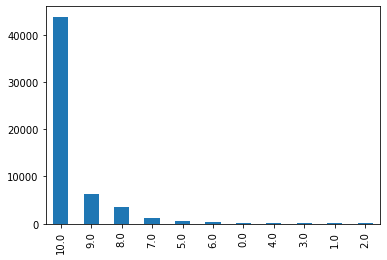

In [62]:
# Visualize SCORE distribution, total 11 scores, majority SCORE = 10
df_train['SCORE'].value_counts().plot(kind = 'bar')

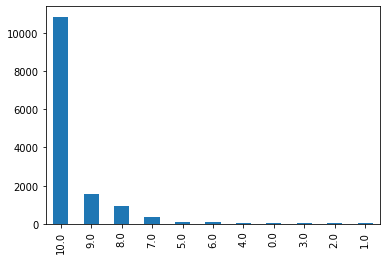

In [63]:
df_validate['SCORE'].value_counts().plot(kind = 'bar')

In [64]:
df_train.isnull().sum()

DOCUMENT_ID           0
SENTENCE_ID           0
SENTENCE              0
SENTENCE_START_POS    0
SENTENCE_END_POS      0
SCORE                 0
dtype: int64

In [65]:
#Remove the missing data 
df_train = df_train.dropna()

In [66]:
df_train.isnull().sum()

DOCUMENT_ID           0
SENTENCE_ID           0
SENTENCE              0
SENTENCE_START_POS    0
SENTENCE_END_POS      0
SCORE                 0
dtype: int64

In [67]:
df_train.shape

(56623, 6)

In [68]:
df_validate.isnull().sum()

DOCUMENT_ID           0
SENTENCE_ID           0
SENTENCE              0
SENTENCE_START_POS    0
SENTENCE_END_POS      0
SCORE                 0
dtype: int64

In [69]:
df_validate = df_validate.dropna()

In [70]:
df_validate.isnull().sum()

DOCUMENT_ID           0
SENTENCE_ID           0
SENTENCE              0
SENTENCE_START_POS    0
SENTENCE_END_POS      0
SCORE                 0
dtype: int64

In [71]:
df_validate.shape

(14014, 6)

## Preprocess Sentences

In [77]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [78]:
# Define preprocess function, remove stop words and punctuations etc.
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import string
stop = set(stopwords.words('english'))
punc = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean_text(text):
    text = text.lower()
    wordList = text.split()
    wordList = ["".join(x for x in word if (x=="'")|(x not in punc)) for word in wordList]
    wordList = [word for word in wordList if word not in stop]
    wordList = [lemma.lemmatize(word) for word in wordList]
    return " ".join(wordList)
clean_text("I Thank you!")

'thank'

In [79]:
# Clean train dataset
df_train["SENTENCE"] = df_train["SENTENCE"].astype("str")
df_train["clean_text"] = df_train["SENTENCE"].apply(clean_text)

In [80]:
# Clean validate dataset
df_validate["SENTENCE"] = df_validate["SENTENCE"].astype("str")
df_validate["clean_text"] = df_validate["SENTENCE"].apply(clean_text)

In [81]:
df_train.head()

,DOCUMENT_ID,SENTENCE_ID,SENTENCE,SENTENCE_START_POS,SENTENCE_END_POS,SCORE,clean_text
0,583306034,1888104,The whole process went smooth and I am thankfu...,109,165,10.0,whole process went smooth thankful
1,583306034,1888102,It was quick and easy to apply and got the app...,0,60,10.0,quick easy apply got approval quickly
2,584193040,1909902,service,0,7,10.0,service
3,584203035,1910310,Thanks!,198,205,10.0,thanks
4,584200037,1910006,Thank you!,58,68,10.0,thank


In [82]:
df_train1 = df_train[['DOCUMENT_ID', 'SCORE', 'clean_text']]

In [83]:
df_train1['clean_text'] = df_train1.groupby(['DOCUMENT_ID'])['clean_text'].transform(lambda x:''.join(x))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [84]:
df_train1 = df_train1.drop_duplicates()

In [85]:
df_train1.shape

(39562, 3)

In [86]:
df_train1.isnull().sum()

DOCUMENT_ID    0
SCORE          0
clean_text     0
dtype: int64

In [87]:
df_pred = df_validate[['DOCUMENT_ID', 'SCORE', 'clean_text']]

In [88]:
df_pred['clean_text'] = df_pred.groupby(['DOCUMENT_ID'])['clean_text'].transform(lambda x:''.join(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [89]:
df_pred = df_pred.drop_duplicates()

In [90]:
df_pred.isnull().sum()

DOCUMENT_ID    0
SCORE          0
clean_text     0
dtype: int64

In [ ]:
#save cleaned data to Google drive
#df_train1.to_csv(path_or_buf='/content/drive/My Drive/Data_Sets/NLP_train.csv')
#df_pred.to_csv(path_or_buf='/content/drive/My Drive/Data_Sets/NLP_validate.csv')

In [ ]:
#upload the cleaned data
#import pandas as pd
#df_train = pd.read_csv('/content/drive/My Drive/Data_Sets/NLP_train.csv')
#df_pred = pd.read_csv('/content/drive/My Drive/Data_Sets/NLP_validate.csv')

In [97]:
df_train1.shape

(39562, 3)

In [ ]:
df_train = df_train.dropna()

In [ ]:
df_train.isnull().sum()

In [98]:
df_pred.shape

(9891, 3)

In [ ]:
df_pred = df_pred.dropna()

In [ ]:
df_pred.isnull().sum()

In [ ]:
#df_train['cat_score']=df_train.SCORE.astype('category').cat.codes

## Import dependences

In [91]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from keras import backend as K

In [92]:
from keras.preprocessing import text, sequence
from keras import optimizers
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, Conv1D, GRU, LSTM, MaxPooling1D, GlobalMaxPool1D
from keras.layers.wrappers import Bidirectional
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import gc



##Split xtrain, ytrain from df_train; xtest, ytest from df_validate;
## one hot encoder 'SCORE'

In [99]:
xtrain = df_train1['clean_text']
ytrain = df_train1['SCORE']
xtest = df_pred['clean_text']
ytest = df_pred['SCORE']

In [100]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(categories='auto',sparse=False)
ohe.fit(ytrain.values.reshape(-1,1))
#max_len=100
max_num_words=10000
tokenizer = text.Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(xtrain)

xtrain = tokenizer.texts_to_sequences(xtrain)
#xtrain = sequence.pad_sequences(xtrain, maxlen = max_len).astype(np.int32)
ytrain = ohe.transform(ytrain.values.reshape(-1,1)).astype(np.uint8)

xtest = tokenizer.texts_to_sequences(xtest)
#xtest = sequence.pad_sequences(xtest, maxlen = max_len).astype(np.int32)
ytest = ohe.transform(ytest.values.reshape(-1,1)).astype(np.uint8)

#xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=10)
#del X, y
#gc.collect()

In [101]:
#import numpy as np
length_train = [len(i) for i in xtrain]
length_test = [len(i) for i in xtest]
lens = length_train + length_test
maxlen = np.max(lens)
maxlen

178

In [102]:
max_len=178
xtrain = sequence.pad_sequences(xtrain, maxlen = max_len).astype(np.int32)
xtest = sequence.pad_sequences(xtest, maxlen = max_len).astype(np.int32)

In [103]:
word_index = tokenizer.word_index
len(word_index)+1   #total tokenized vocabulary from sentence

18212

In [104]:
word_index

{'easy': 1,
 'process': 2,
 'quick': 3,
 'loan': 4,
 'fast': 5,
 'service': 6,
 'ease': 7,
 'rate': 8,
 'application': 9,
 'best': 10,
 'customer': 11,
 'interest': 12,
 'egg': 13,
 'great': 14,
 'simple': 15,
 'get': 16,
 'time': 17,
 'response': 18,
 'credit': 19,
 'good': 20,
 'approval': 21,
 'apply': 22,
 'money': 23,
 'fund': 24,
 'account': 25,
 'day': 26,
 'friendly': 27,
 'helpful': 28,
 'payment': 29,
 'efficient': 30,
 'approved': 31,
 'use': 32,
 'hassle': 33,
 'speed': 34,
 'quickly': 35,
 'funding': 36,
 'would': 37,
 'pay': 38,
 'professional': 39,
 'help': 40,
 'getting': 41,
 'high': 42,
 'everything': 43,
 'online': 44,
 'needed': 45,
 'experience': 46,
 'received': 47,
 'card': 48,
 'applying': 49,
 'work': 50,
 'fee': 51,
 'got': 52,
 'convenient': 53,
 'score': 54,
 'one': 55,
 'excellent': 56,
 'made': 57,
 'within': 58,
 'bank': 59,
 'need': 60,
 'debt': 61,
 'company': 62,
 'able': 63,
 'super': 64,
 'question': 65,
 'people': 66,
 'like': 67,
 'deposited': 68,


## Build word embedding matrix from glove 100d

In [105]:
f= open('/content/drive/My Drive/Data_Sets/glove.6B.100d.txt', 'r', encoding='utf-8')
embeddings_index={}
for line in f:
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except ValueError:
        pass
f.close()

word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [106]:
embedding_matrix[1]

array([-5.86719990e-01,  2.07139999e-01,  6.44829988e-01,  1.02509998e-01,
        1.16729997e-01,  2.39500001e-01, -3.56759988e-02,  4.47730022e-03,
        3.08140010e-01, -1.57590002e-01,  3.71190012e-01,  2.73669995e-02,
       -4.54329997e-01, -2.15890005e-01,  4.79779989e-01,  2.21220002e-01,
       -2.10010004e-03,  1.51910007e-01, -2.03879997e-01,  6.64740026e-01,
        1.96899995e-01,  5.19959986e-01,  3.08739990e-01, -7.27029979e-01,
        3.52360010e-02,  3.74469995e-01, -5.12489974e-01, -5.72700024e-01,
        5.00289984e-02, -6.15499973e-01, -7.04850018e-01,  5.34030020e-01,
       -1.46860003e-01, -2.88480014e-01,  1.02740002e+00,  3.29690009e-01,
       -5.95439970e-01, -1.88219994e-01,  3.09269994e-01, -5.00720024e-01,
        1.94499999e-01, -3.11150014e-01, -1.30909994e-01, -8.10490012e-01,
       -3.21590006e-01, -3.99820000e-01,  5.42590022e-01, -3.00700009e-01,
        1.49220005e-01, -6.27300024e-01,  2.31209993e-02,  2.41059996e-02,
       -1.16380001e-03,  

## Build CNN + Bidirectional LSTM Neural Network 
## Train the model

In [107]:
nlabels=11

model = Sequential()
model.add(Embedding(len(word_index)+1,
                           100,
                           weights=[embedding_matrix],
                           input_length=max_len,
                           trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
#model.add(Bidirectional(GRU(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
#model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(nlabels, activation='softmax')) #'sigmoid'
model.compile(loss='categorical_crossentropy',
                optimizer='adam', 
                metrics=['acc'])
model.summary()

batch=512
epoch=15

history = model.fit(xtrain, ytrain,
                    validation_split=0.2,
                    epochs=epoch,
                    batch_size=batch,
                   verbose=1)
score, acc = model.evaluate(xtest, ytest,
                            batch_size=batch)
#model.save('lstm_model.h5')



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 178, 100)          1821200   
                                                                 
 spatial_dropout1d (SpatialD  (None, 178, 100)         0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 176, 64)           19264     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 88, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 86, 32)            6176      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 43, 32)           0

In [108]:
model.save('/content/drive/My Drive/Data_Sets/lstm_model.h5')

## Plot loss and Accuracy vs. Epoch

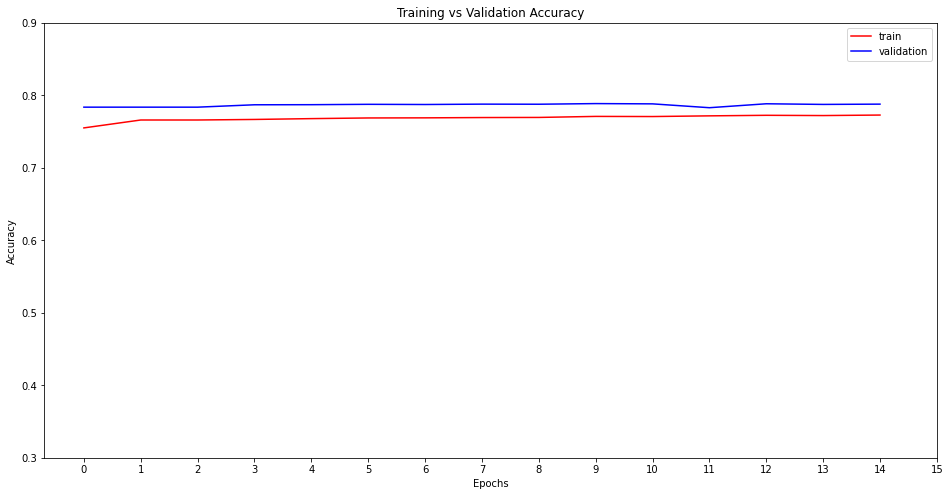

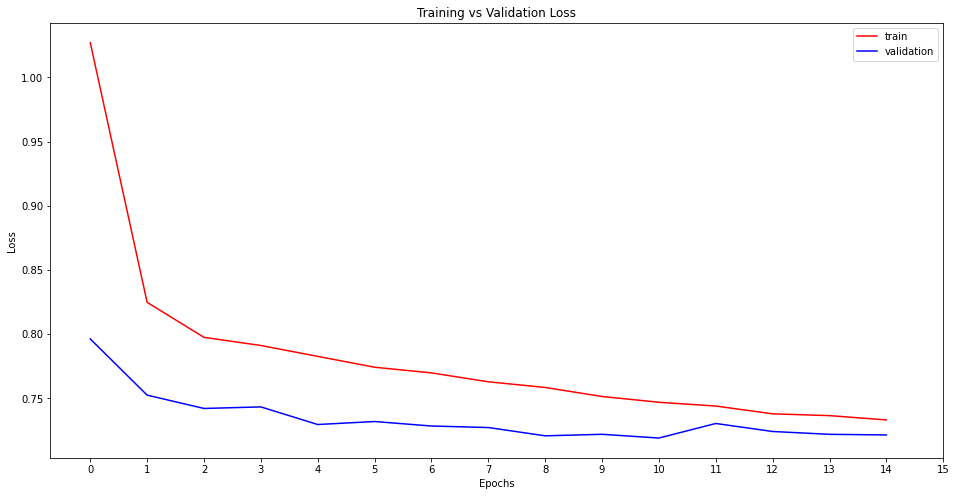

In [109]:
plt.figure(figsize = (16, 8))
plt.plot(history.history['acc'], color='red')
plt.plot(history.history['val_acc'], color='blue')
plt.xticks(np.arange(0, epoch + 1))
plt.yticks(np.arange(0.3, 1, 0.1))
plt.rcParams['figure.figsize'] = (10, 6)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend(['train','validation'])
plt.show()

plt.figure(figsize = (16, 8))
plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='blue')
plt.xticks(np.arange(0, epoch + 1))
plt.rcParams['figure.figsize'] = (5, 3)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend(['train','validation'])
plt.show()

In [110]:
ypred = model.predict(xtest)
ypred = np.argmax(ypred, axis=1)
ytest = np.argmax(ytest, axis=1)

In [111]:
from sklearn.metrics import classification_report
target_names = ['0','1','2','3','4','5','6','7','8','9','10']
print(classification_report(ytest, ypred, target_names = target_names))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        17
           5       0.13      0.03      0.05        66
           6       0.00      0.00      0.00        63
           7       0.00      0.00      0.00       221
           8       0.30      0.14      0.19       679
           9       0.00      0.00      0.00      1180
          10       0.79      0.99      0.88      7612

    accuracy                           0.77      9891
   macro avg       0.11      0.11      0.10      9891
weighted avg       0.63      0.77      0.69      9891



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [112]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, ypred)
print(cm)

[[   0    0    0    0    0    0    0    0   11    0   11]
 [   0    0    0    0    0    0    0    0    4    0    3]
 [   0    0    0    0    0    2    0    0    6    0    2]
 [   0    0    0    0    0    1    0    0    5    0    8]
 [   0    0    0    0    0    1    0    0    8    0    8]
 [   0    0    0    0    0    2    0    0   29    0   35]
 [   0    0    0    0    0    0    0    0   25    0   38]
 [   0    0    0    0    0    3    0    0   59    0  159]
 [   0    0    0    0    0    2    0    0   95    0  582]
 [   0    0    0    0    0    1    0    0   22    0 1157]
 [   0    0    0    0    0    3    0    0   54    0 7555]]


## ANN: 3 Dense Layers

In [1]:
#upload the cleaned data
import pandas as pd
df_train = pd.read_csv('/content/drive/My Drive/Data_Sets/NLP_train.csv')
df_pred = pd.read_csv('/content/drive/My Drive/Data_Sets/NLP_validate.csv')

In [2]:
df_train.shape

(39562, 4)

In [3]:
df_train = df_train.dropna()

In [4]:
df_train.isnull().sum()

Unnamed: 0     0
DOCUMENT_ID    0
SCORE          0
clean_text     0
dtype: int64

In [5]:
df_pred.shape

(9891, 4)

In [6]:
df_pred = df_pred.dropna()

In [7]:
df_pred.isnull().sum()

Unnamed: 0     0
DOCUMENT_ID    0
SCORE          0
clean_text     0
dtype: int64

In [8]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from keras import backend as K

In [9]:
from keras.preprocessing import text, sequence
from keras import optimizers
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, Conv1D, GRU, LSTM, MaxPooling1D, GlobalMaxPool1D
from keras.layers.wrappers import Bidirectional
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import gc

In [10]:
xtrain = df_train['clean_text']
ytrain = df_train['SCORE']
xtest = df_pred['clean_text']
ytest = df_pred['SCORE']

In [11]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(categories='auto',sparse=False)
ohe.fit(ytrain.values.reshape(-1,1))
max_num_words=10000
tokenizer = text.Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(xtrain)

xtrain = tokenizer.texts_to_sequences(xtrain)
ytrain = ohe.transform(ytrain.values.reshape(-1,1)).astype(np.uint8)

xtest = tokenizer.texts_to_sequences(xtest)
ytest = ohe.transform(ytest.values.reshape(-1,1)).astype(np.uint8)

In [12]:
#import numpy as np
length_train = [len(i) for i in xtrain]
length_test = [len(i) for i in xtest]
lens = length_train + length_test
maxlen = np.max(lens)
maxlen

178

In [13]:
max_len=178
xtrain = sequence.pad_sequences(xtrain, maxlen = max_len).astype(np.int32)
xtest = sequence.pad_sequences(xtest, maxlen = max_len).astype(np.int32)

In [14]:
f= open('/content/drive/My Drive/Data_Sets/glove.6B.100d.txt', 'r', encoding='utf-8')
embeddings_index={}
for line in f:
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except ValueError:
        pass
f.close()

word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [15]:
nlabels=11

model = Sequential()
model.add(Embedding(len(word_index)+1,
                           100,
                           weights=[embedding_matrix],
                           input_length=max_len,
                           trainable=False))
#model.add(SpatialDropout1D(0.3))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(nlabels, activation='softmax')) #'sigmoid'
model.compile(loss='categorical_crossentropy',
                optimizer='adam', 
                metrics=['acc'])
model.summary()

batch=512
epoch=30

history = model.fit(xtrain, ytrain,
                    validation_split=0.2,
                    epochs=epoch,
                    batch_size=batch,
                   verbose=1)
score, acc = model.evaluate(xtest, ytest,
                            batch_size=batch)
#model.save('lstm_model.h5')



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 178, 100)          1821200   
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 512)               51712     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [16]:
model.save('/content/drive/My Drive/Data_Sets/ANN_model.h5')

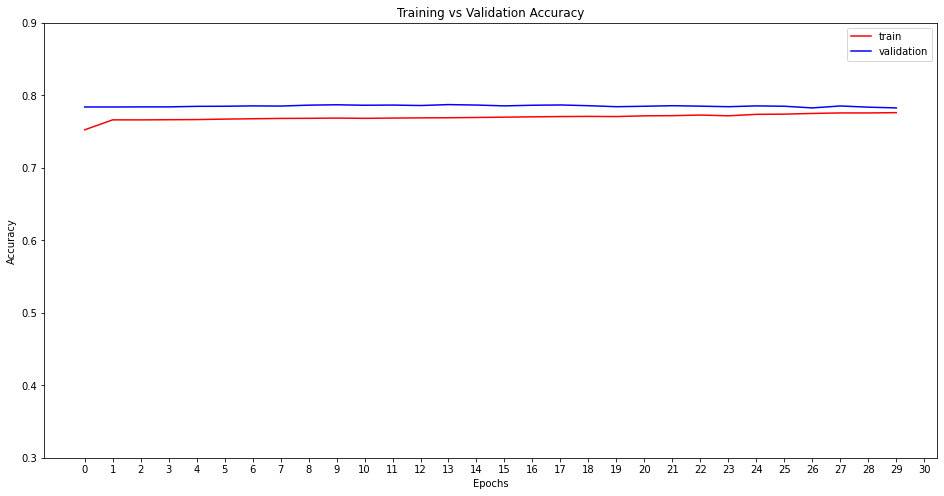

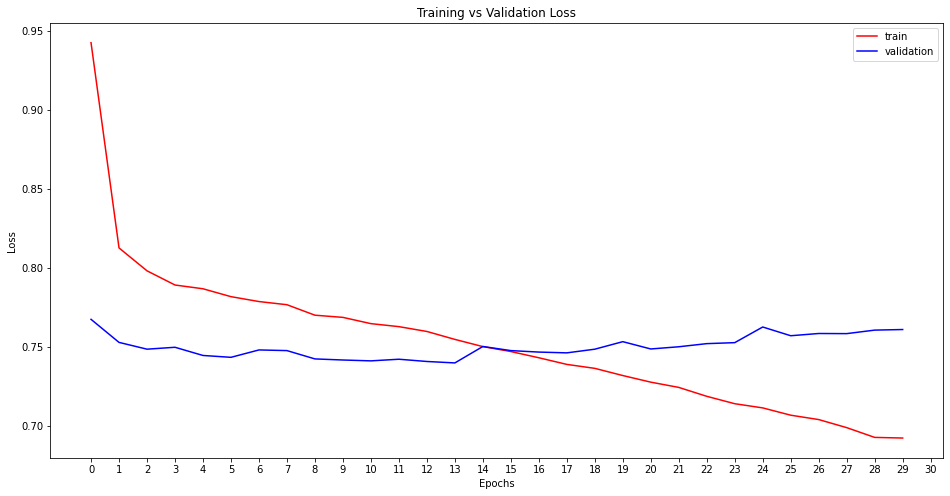

In [17]:
plt.figure(figsize = (16, 8))
plt.plot(history.history['acc'], color='red')
plt.plot(history.history['val_acc'], color='blue')
plt.xticks(np.arange(0, epoch + 1))
plt.yticks(np.arange(0.3, 1, 0.1))
plt.rcParams['figure.figsize'] = (10, 6)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend(['train','validation'])
plt.show()

plt.figure(figsize = (16, 8))
plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='blue')
plt.xticks(np.arange(0, epoch + 1))
plt.rcParams['figure.figsize'] = (5, 3)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend(['train','validation'])
plt.show()

In [18]:
ypred = model.predict(xtest)
ypred = np.argmax(ypred, axis=1)
ytest = np.argmax(ytest, axis=1)

In [19]:
from sklearn.metrics import classification_report
target_names = ['0','1','2','3','4','5','6','7','8','9','10']
print(classification_report(ytest, ypred, target_names = target_names))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        17
           5       0.08      0.05      0.06        66
           6       0.10      0.02      0.03        62
           7       0.14      0.02      0.03       220
           8       0.31      0.08      0.13       679
           9       0.15      0.00      0.01      1179
          10       0.79      0.99      0.88      7605

    accuracy                           0.77      9881
   macro avg       0.14      0.10      0.10      9881
weighted avg       0.65      0.77      0.69      9881



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, ypred)
print(cm)

[[   0    0    0    0    0    1    1    3    4    0   13]
 [   0    0    0    0    0    0    0    1    2    0    4]
 [   0    0    0    0    0    2    0    0    2    0    6]
 [   0    0    0    0    0    2    0    2    1    0    9]
 [   0    0    0    1    0    1    0    0    1    0   14]
 [   0    0    0    0    0    3    2    3   13    0   45]
 [   0    0    0    1    0    7    1    1   18    1   33]
 [   0    0    0    1    0    5    2    4   23    2  183]
 [   0    0    0    0    0    8    3    9   54    6  599]
 [   0    0    0    0    0    4    0    0   13    4 1158]
 [   0    0    0    0    1    4    1    5   42   14 7538]]


## BERT

In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
path='/content/drive/My Drive/Data_Sets/'
df_train = pd.read_csv(path+'NLP_task_train.csv.zip',header=0,index_col=0,compression='infer')
df_validate = pd.read_csv(path+'NLP_task_validate.csv.zip',header=0,index_col=0,compression='infer')

In [3]:
df_train.isnull().sum()

DOCUMENT_ID            0
SENTENCE_ID            0
SENTENCE              21
SENTENCE_START_POS     0
SENTENCE_END_POS       0
SCORE                  0
dtype: int64

In [4]:
#Remove the missing data 
df_train = df_train.dropna()

In [5]:
df_validate.isnull().sum()

DOCUMENT_ID           0
SENTENCE_ID           0
SENTENCE              4
SENTENCE_START_POS    0
SENTENCE_END_POS      0
SCORE                 1
dtype: int64

In [6]:
df_validate = df_validate.dropna()

In [7]:
df_train1 = df_train[['DOCUMENT_ID', 'SCORE', 'SENTENCE']]


In [8]:
df_train1['SENTENCE'] = df_train1.groupby(['DOCUMENT_ID'])['SENTENCE'].transform(lambda x:''.join(x))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
df_train1 = df_train1.drop_duplicates()

In [10]:
df_train1.head()

,DOCUMENT_ID,SCORE,SENTENCE
0,583306034,10.0,The whole process went smooth and I am thankfu...
2,584193040,10.0,service
3,584203035,10.0,Thanks!I paid off a best egg I had in the past...
4,584200037,10.0,"Thank you!Ease of use, fast customer service, ..."
6,584204033,8.0,Ease and quickness of funding the loan


In [ ]:
df_train1.shape

In [11]:
df_pred = df_validate[['DOCUMENT_ID', 'SCORE', 'SENTENCE']]

In [12]:
df_pred['SENTENCE'] = df_pred.groupby(['DOCUMENT_ID'])['SENTENCE'].transform(lambda x:''.join(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
df_pred = df_pred.drop_duplicates()

In [14]:
df_pred.head()

,DOCUMENT_ID,SCORE,SENTENCE
7,584207033,10.0,The loan process was super easy
10,584199033,9.0,The process was quick and easy!
13,591377035,10.0,were in my bank within just a few days from th...
25,34211545,10.0,Very expensive dental work and debt consolidat...
26,34211856,10.0,thanks againjust the quick service provided to...


In [15]:
df_train1 = pd.get_dummies(df_train1,columns=['SCORE'])

In [16]:
df_test = pd.get_dummies(df_pred,columns=['SCORE'])  # change df_pred as df_test, so we can use df_pred later

In [17]:
df_train1.head()

,DOCUMENT_ID,SENTENCE,SCORE_0.0,SCORE_1.0,SCORE_2.0,SCORE_3.0,SCORE_4.0,SCORE_5.0,SCORE_6.0,SCORE_7.0,SCORE_8.0,SCORE_9.0,SCORE_10.0
0,583306034,The whole process went smooth and I am thankfu...,0,0,0,0,0,0,0,0,0,0,1
2,584193040,service,0,0,0,0,0,0,0,0,0,0,1
3,584203035,Thanks!I paid off a best egg I had in the past...,0,0,0,0,0,0,0,0,0,0,1
4,584200037,"Thank you!Ease of use, fast customer service, ...",0,0,0,0,0,0,0,0,0,0,1
6,584204033,Ease and quickness of funding the loan,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
#xtrain = df_train1['SENTENCE']
#ytrain = df_train1['SCORE']
#xtest = df_pred['SENTENCE']
#ytest = df_pred['SCORE']

In [18]:
!pip install texthero

     |████████████████████████████████| 1.5 MB 7.3 MB/s 
     |████████████████████████████████| 235 kB 46.4 MB/s 
     |████████████████████████████████| 749 kB 45.6 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [19]:
!pip install tensorflow-text

     |████████████████████████████████| 4.9 MB 5.2 MB/s 


In [20]:
!pip install tf-models-official

     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 99 kB 8.7 MB/s 
     |████████████████████████████████| 47.7 MB 2.5 MB/s 
     |████████████████████████████████| 213 kB 38.5 MB/s 
     |████████████████████████████████| 90 kB 9.5 MB/s 
     |████████████████████████████████| 352 kB 50.7 MB/s 
     |████████████████████████████████| 596 kB 47.8 MB/s 
     |████████████████████████████████| 1.2 MB 48.1 MB/s 
     |████████████████████████████████| 1.1 MB 48.1 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22258 sha256=954bfb261d97b8ed460805970ee0d01ba0a17c818e19ba461ebe1ee6a1f52d5e
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=e6f01f3631b8a49ed60343bf3e94b93765e414a7b7bb615a343d8823d8419c35
  Stored i

In [21]:
import texthero as hero
from texthero import preprocessing

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [22]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization 

In [23]:
# before feeding the data to the model, we will clean it a bit
clean_text_bert_pipeline = [
               preprocessing.remove_urls, # remove urls
               preprocessing.remove_diacritics,
               preprocessing.remove_whitespace  # remove any extra spaces
               ]
train_bert = hero.clean(df_train1['SENTENCE'], clean_text_bert_pipeline)
test_bert = hero.clean(df_test['SENTENCE'], clean_text_bert_pipeline)

In [24]:
# create targets
labels = ['SCORE_0.0','SCORE_1.0','SCORE_2.0','SCORE_3.0','SCORE_4.0','SCORE_5.0','SCORE_6.0','SCORE_7.0','SCORE_8.0','SCORE_9.0','SCORE_10.0']
ytrain = df_train1[labels]
ytest = df_test[labels]

In [25]:
# creating tensorflow dataset
# Preparaing the data to feed into the model
batch_size = 32
seed = 42

#train_ds = tf.data.Dataset.from_tensor_slices((train_bert.values, y_train.values)).shuffle(50000).batch(batch_size)
#test_ds = tf.data.Dataset.from_tensor_slices((test_bert.values, y_test.values)).shuffle(50000).batch(batch_size)
train_ds = tf.data.Dataset.from_tensor_slices((train_bert.values, ytrain.values)).shuffle(40000).batch(batch_size) #size 39562
test_ds = tf.data.Dataset.from_tensor_slices((test_bert.values, ytest.values)).shuffle(10000).batch(batch_size)  # size 9891

In [26]:
for train_batch in train_ds.take(1):
  print(train_batch[:2])

(<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'3 reasons one the ease of navigation through the process, two competitive interest rate and terms and number three the quick turnaround time from completing the application to receiving the funds was outstanding.',
       b'good credit history', b'Quick and Easy!',
       b'easy application process', b'The simple way to applied',
       b'Fees were a bit high...is my only complaint....Process was very easy and service quite good.and kept me from giving highest score possible.',
       b'It was easy', b'Very simple, quick and easy.',
       b'The customer service with Best Egg is great.I appreciated the follow up call letting me know all went well with my submission and the turnaround time to receive the payment was quicker than expected.',
       b'It was a decent experience, but since you will not allow your loans to be added to mint, it is annoying to try to track it.',
       b'Good rates', b'Ease of loan',
       b'Quick Respo

### Loading the models form tensorflow hub

In [27]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [28]:
# create keras model 
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(500, activation='relu')(net)
  #net = tf.keras.layers.Dense(11, activation= "sigmoid" , name='classifier')(net)
  net = tf.keras.layers.Dense(11, activation= "softmax" , name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [29]:
classifier_model = build_classifier_model()
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [30]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [tf.metrics.BinaryAccuracy(), tf.metrics.AUC(multi_label=True)]

In [31]:
#epochs = 20
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [32]:
# compile the model
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
#callbacks = [tf.keras.callbacks.ModelCheckpoint('best_bert_model', save_best_only=True),
#             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]

In [34]:
# train the model
bert_history = classifier_model.fit(train_ds, 
                               #validation_split=0.2, #`validation_split` is only supported for Tensors or NumPy arrays
                               validation_data=test_ds, 
                               epochs = epochs) 
                               #callbacks = callbacks)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning:

"`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"



1237/1237 [==============================] - 384s 304ms/step - loss: 0.1633 - binary_accuracy: 0.9542 - auc: 0.6321 - val_loss: 0.1126 - val_binary_accuracy: 0.9611 - val_auc: 0.7743
Epoch 2/5
1237/1237 [==============================] - 375s 303ms/step - loss: 0.1128 - binary_accuracy: 0.9614 - auc: 0.7919 - val_loss: 0.1117 - val_binary_accuracy: 0.9617 - val_auc: 0.8384
Epoch 3/5
1237/1237 [==============================] - 374s 302ms/step - loss: 0.1096 - binary_accuracy: 0.9622 - auc: 0.8261 - val_loss: 0.1108 - val_binary_accuracy: 0.9618 - val_auc: 0.8113
Epoch 4/5
1237/1237 [==============================] - 374s 303ms/step - loss: 0.1068 - binary_accuracy: 0.9627 - auc: 0.8528 - val_loss: 0.1107 - val_binary_accuracy: 0.9618 - val_auc: 0.8220
Epoch 5/5
1237/1237 [==============================] - 375s 303ms/step - loss: 0.1053 - binary_accuracy: 0.9631 - auc: 0.8604 - val_loss: 0.1106 - val_binary_accuracy: 0.9616 - val_auc: 0.8175


In [35]:
classifier_model.save('/content/drive/My Drive/Data_Sets/bert_model.h5')

In [36]:
bert_history.history

{'auc': [0.6321074962615967,
  0.7919397950172424,
  0.8260789513587952,
  0.8528080582618713,
  0.8604019284248352],
 'binary_accuracy': [0.9541887044906616,
  0.9614459872245789,
  0.9622320532798767,
  0.9626548290252686,
  0.9630520343780518],
 'loss': [0.1632910817861557,
  0.11282731592655182,
  0.10956469923257828,
  0.10684607177972794,
  0.10527828335762024],
 'val_auc': [0.7742621898651123,
  0.8383785486221313,
  0.8113361597061157,
  0.8220072388648987,
  0.8174703121185303],
 'val_binary_accuracy': [0.9611125588417053,
  0.9616549611091614,
  0.9617555141448975,
  0.9617834687232971,
  0.9615720510482788],
 'val_loss': [0.1126142367720604,
  0.11168230324983597,
  0.11082388460636139,
  0.11071190237998962,
  0.11057872325181961]}

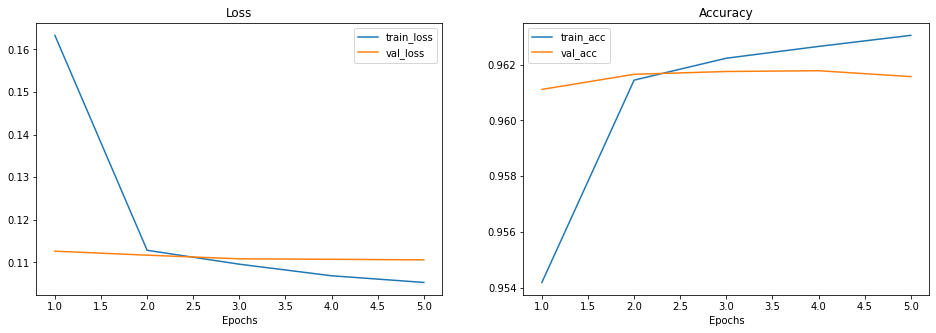

In [40]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize = (16,5))
epochs = [i for i in range(1,6)]
ax[0].plot(epochs, bert_history.history['loss'], label = 'train_loss');
ax[0].plot(epochs, bert_history.history['val_loss'], label = 'val_loss');
ax[0].set_title("Loss");
ax[0].set_xlabel("Epochs")
ax[0].legend();
ax[1].plot(epochs, bert_history.history['binary_accuracy'], label = 'train_acc');
ax[1].plot(epochs, bert_history.history['val_binary_accuracy'], label = 'val_acc');
ax[1].set_title("Accuracy");
ax[1].set_xlabel("Epochs")
ax[1].legend();


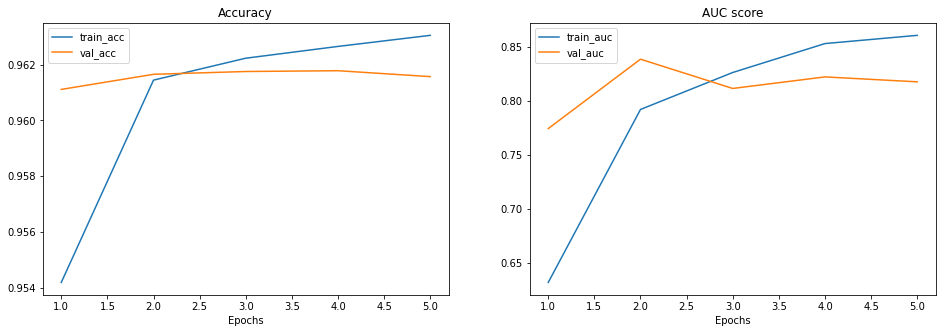

In [38]:
# performance curve
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize = (16,5))
epochs = [i for i in range(1,6)]
ax[0].plot(epochs, bert_history.history['binary_accuracy'], label = 'train_acc');
ax[0].plot(epochs, bert_history.history['val_binary_accuracy'], label = 'val_acc');
ax[0].set_title("Accuracy");
ax[0].set_xlabel("Epochs")
ax[0].legend();

ax[1].plot(epochs, bert_history.history['auc'], label = 'train_auc');
ax[1].plot(epochs, bert_history.history['val_auc'], label = 'val_auc');
ax[1].set_title("AUC score");
ax[1].set_xlabel("Epochs")
ax[1].legend();


In [ ]:
#ax[1].plot(epochs, bert_history.history['auc'], label = 'train_auc');
#ax[1].plot(epochs, bert_history.history['val_auc'], label = 'val_auc');
#ax[1].set_title("AUC score");
#ax[1].set_xlabel("Epochs")
#ax[1].legend();

In [ ]:
# load the best model
#bert_model = tf.keras.models.load_model('best_bert_model', compile = False)

In [41]:
# compile the model
classifier_model.compile(optimizer=optimizer, loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=metrics)

In [42]:
loss, accuracy,auc = classifier_model.evaluate(test_ds)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning:

"`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"



310/310 [==============================] - 53s 168ms/step - loss: 0.1106 - binary_accuracy: 0.9616 - auc: 0.8175


In [44]:
import numpy as np
print(f"Accuracy: {np.round(accuracy,4)}")
print(f"AUC: {np.round(auc,4)}")
print(f"Logloss: {np.round(loss,4)}")

Accuracy: 0.9616
AUC: 0.8175
Logloss: 0.1106


In [45]:
ypred = classifier_model.predict(test_ds)
ypred = np.argmax(ypred, axis=1)
ytest = np.argmax(ytest.values, axis=1)

In [46]:
from sklearn.metrics import classification_report
target_names = ['0','1','2','3','4','5','6','7','8','9','10']
print(classification_report(ytest, ypred, target_names = target_names))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        17
           5       0.03      0.02      0.02        66
           6       0.00      0.00      0.00        63
           7       0.06      0.01      0.02       221
           8       0.08      0.05      0.06       679
           9       0.10      0.00      0.01      1180
          10       0.77      0.94      0.85      7612

    accuracy                           0.73      9891
   macro avg       0.09      0.09      0.09      9891
weighted avg       0.61      0.73      0.66      9891



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [48]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, ypred)
print(cm)

[[   0    0    0    0    0    0    0    0    0    0   22]
 [   0    0    0    0    0    0    0    0    0    0    7]
 [   0    0    0    0    0    0    0    0    1    0    9]
 [   0    0    0    0    0    0    0    1    0    0   13]
 [   0    0    0    0    0    0    0    0    0    0   17]
 [   0    0    0    0    0    1    0    0    0    1   64]
 [   0    0    0    0    0    0    0    1    3    0   59]
 [   0    0    0    0    0    1    0    3    9    0  208]
 [   0    0    0    0    0    3    0    4   33    4  635]
 [   0    0    0    0    0    3    0   12   60    5 1100]
 [   4    0    0    0    0   25    0   32  324   38 7189]]


In [49]:
df_pred['Prediction'] = ypred

In [50]:
df_pred['Evaluation'] = [[1]*11]*len(ypred)

In [51]:
for index, row in df_pred.iterrows():
  df_pred['Evaluation'][index] = cm[int(row.SCORE)]   # SCORE has encoded, need to use previous df--change name

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [52]:
df_pred.head()

,DOCUMENT_ID,SCORE,SENTENCE,Prediction,Evaluation
7,584207033,10.0,The loan process was super easy,10,"[4, 0, 0, 0, 0, 25, 0, 32, 324, 38, 7189]"
10,584199033,9.0,The process was quick and easy!,10,"[0, 0, 0, 0, 0, 3, 0, 12, 60, 5, 1100]"
13,591377035,10.0,were in my bank within just a few days from th...,10,"[4, 0, 0, 0, 0, 25, 0, 32, 324, 38, 7189]"
25,34211545,10.0,Very expensive dental work and debt consolidat...,10,"[4, 0, 0, 0, 0, 25, 0, 32, 324, 38, 7189]"
26,34211856,10.0,thanks againjust the quick service provided to...,10,"[4, 0, 0, 0, 0, 25, 0, 32, 324, 38, 7189]"


In [54]:
df_pred.tail()

,DOCUMENT_ID,SCORE,SENTENCE,Prediction,Evaluation
70625,689811033,8.0,The speed in which the process was taken was e...,10,"[0, 0, 0, 0, 0, 3, 0, 4, 33, 4, 635]"
70645,689884033,10.0,Quick and easy with a low loan interest rate i...,10,"[4, 0, 0, 0, 0, 25, 0, 32, 324, 38, 7189]"
70646,689562033,5.0,The prompt decision,10,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 64]"
70652,689568034,10.0,paying bills,10,"[4, 0, 0, 0, 0, 25, 0, 32, 324, 38, 7189]"
70655,689550034,10.0,It was quick and easy process,10,"[4, 0, 0, 0, 0, 25, 0, 32, 324, 38, 7189]"


# Summary and Improvement:

## 1. CNN + Bidirectional LSTM, ANN and Bert neural networks were built for NLP multi-class predictions with imbalance data. 
## 2. The CNN/BiLSTM model accuracy reached 0.77, which is the same as Bidirectional GRU neural network; tweaked neural networks and hyperparameters, but didn't help to improve the performance. However, the runtime is more than 10 times fast with adding CNN layer.
## 3. ANN model consists only 3 dense layers which reached the same accuray as model of CNN/BiLSTM, and is very fast!
## 4. BERT, train acc 0.963, validation acc 0.962, outperformance than CNN/BiLSTM and ANN models! But prediction is still not good. 

## Improvement:
## 1. Data quality is very important for neural network models training and prediction. Understand the domain knowledge of dataset, which may help the data preprocessing, such as combine some minority classes to be 1 class, reduce total number of classes.
## 2. Oversampling: For the words, using nlpaug, try 'substitute', and 'insert' options.       
## 3. Try transformer GPT-2, other pre-trained BERT models which might be outperformence GRU, LSTM etc. recurrent neural networks.

